#### Import all needed libraries

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.optim import Adam
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader,Dataset
import torchvision.models as models

import time
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm,trange

from Trainer import ModelTrainer

# from Trainer import ModelTrainer

#### adding basic parameters


In [2]:
# the size of our mini batches
batch_size=64

# number of epochs
num_epochs = 10

# optimizier learning rate
learning_rate = 1e-3 # 0.001

start_epoch = 0

# Initialise best valid accuracy
best_valid_acc = 0

# Where to save/load dataset from
data_set_root = "../../datasets"

# What to resize our images
image_size = 96

In [3]:
start_from_checkpoint = False

save_dir = '../data/Models'
model_name = 'ResNet18_STL3'

In [4]:
gpu_idx = 0
device = torch.device(f'cuda:{gpu_idx}' if torch.cuda.is_available() else 'cpu')

### **Some preproccess to the dataset: Convert the images to tensor**

In [5]:
transform = transforms.Compose([
  transforms.Resize((96,96)),
  transforms.ToTensor(),
  transforms.Normalize(mean=[0.485,0.456,0.406],
                        std=[0.229,0.224,0.225])
])

In [6]:
train_data = datasets.STL10(data_set_root,split='train',download=True,transform=transform)
test_data = datasets.STL10(data_set_root,split='test',download=True,transform=transform)

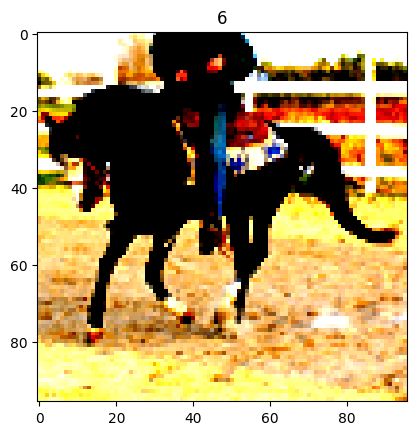

In [7]:
for data in test_data:
  img,label = data

  plt.imshow(img.permute(1,2,0))
  plt.title(str(label))
  plt.show()

  break

In [30]:
validation_split = 0.1  # if you want 10% validation
n_total = len(train_data)
n_valid_examples = int(n_total * validation_split)
n_train_examples = n_total - n_valid_examples

train_data, valid_data = torch.utils.data.random_split(
    train_data,
    [n_train_examples, n_valid_examples],
    generator=torch.Generator().manual_seed(42)
)

### **What is weight "Freezing"?**

by weight freezing, we can free early layers of pre-trained model. We don't need to train entire network, can only train part of this. Weight freezing is where we freeze all those convulutional layers and only train the last linear layer

In [31]:
res_net = models.resnet18(pretrained=False).to(device)

In [32]:
res_net

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

The ImageNet challenge dataset that the ResNet model was train on has 1000 classes but STL 10 has dataset has only 10. We can still use the pretrained model we just need to alter it a bit by simply replacing the last FC (linear) layer with new one

In [33]:
# uncomment this when ready
# loop through all the learnable parameter objects (from the layers)

for param in res_net.parameters():
  # set to true unfreeze layers
  param.requires_grad = False

In [34]:
# Augment the model, by swapping out the last fc layer for a different one
# get the number of in features into last fc layer
num_ftrs = res_net.fc.in_features

# Redefine the last fc layer with a linear layer with 10 outputs
# this layer's weights will be randomly initialised
res_net.fc = nn.Linear(num_ftrs,10).to(device)

In [35]:
model_trainer = ModelTrainer(
    model=res_net,
    device=device,
    loss_fun=nn.CrossEntropyLoss(),
    batch_size=batch_size,
    learning_rate=learning_rate,
    save_dir=save_dir,
    model_name=model_name,
    start_from_checkpoint=start_from_checkpoint
)

ValueError: Warning Checkpoint exists

In [37]:
model_trainer.set_data(train_set=train_data,test_set=test_data,val_set=valid_data)

Number of training examples: 4050
Number of validation examples: 450
Number of testing examples: 8000


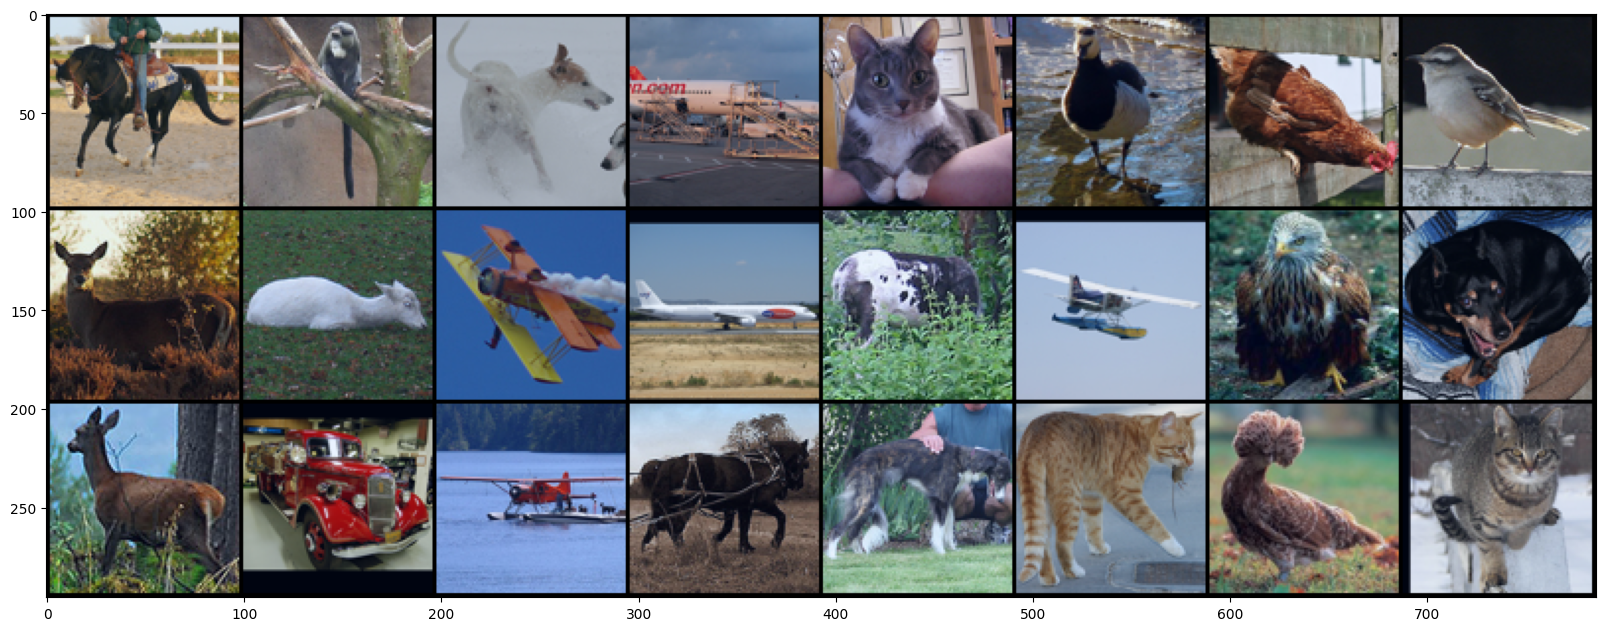

In [38]:
plt.figure(figsize=(20,10))
images,labels = next(iter(model_trainer.test_loader))
out = torchvision.utils.make_grid(images[0:24],normalize=True)
plt.imshow(out.numpy().transpose(1,2,0))

In [39]:
# Let's see how many parameters our model has
num_params=0
for param in res_net.parameters():
  num_params += param.flatten().shape[0]

print(f" This model has  %d (approximately %d Million) parameters" % (num_params, num_params//1e6))

 This model has  11181642 (approximately 11 Million) parameters


In [40]:
# thiss cell implements out training loop
# Record the start time
start_time = time.time()
valid_acc = 0
train_acc = 0

pbar = trange(start_epoch, num_epochs, leave=False, desc='Epoch')

for epoch in pbar:
  pbar.set_postfix_str('Accuracy: Train %.2f%%, Val: %.2f%%' % (train_acc * 100, valid_acc*100))

  # Call the training function and pass training for train and validation etc
  model_trainer.train_model()

  # call the modules evaluete function for train and validation set
  train_acc = model_trainer.evaluate_model(train_test_val='train')
  valid_acc = model_trainer.evaluate_model(train_test_val='val')

  # Check if the the current validation accuracy is greater than previous best
  # if so, then save the model
  if valid_acc > model_trainer.best_valid_acc:
    model_trainer.save_checkpoint(epoch,valid_acc)

end_time = time.time()

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/8 [00:00<?, ?it/s]

In [24]:
train_acc

0.43

In [25]:
print(f"The highest validation accuracy was %.2f%%" % (model_trainer.best_valid_acc*100))

The highest validation accuracy was 31.00%


In [26]:
print(f"Training time %.2f seconds" % (end_time - start_time))

Training time 73.98 seconds


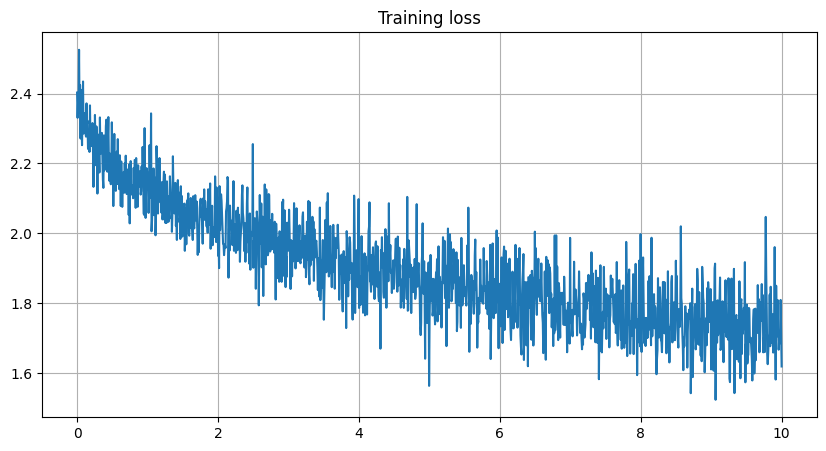

In [27]:
_ = plt.figure(figsize=(10,5))
train_x = np.linspace(0,num_epochs,len(model_trainer.train_loss_logger))
plt.plot(train_x,model_trainer.train_loss_logger)
plt.title('Training loss')
plt.grid()
plt.show()

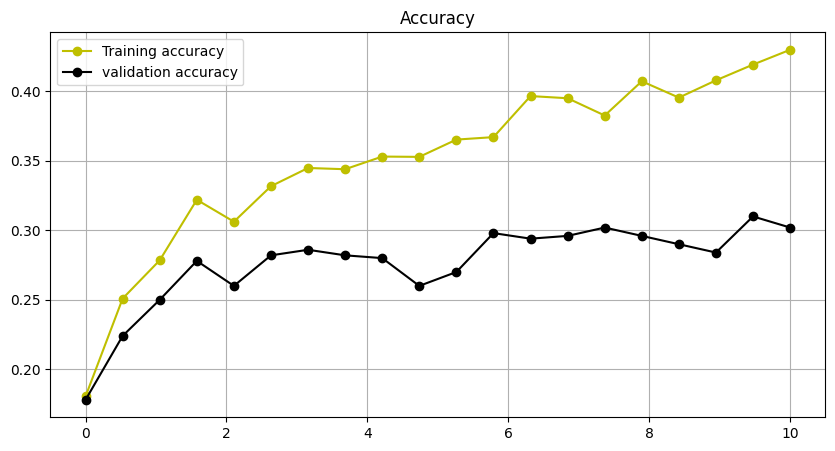

In [28]:
_ = plt.figure(figsize=(10,5))
train_x = np.linspace(0,num_epochs,len(model_trainer.train_acc_logger))
_ = plt.plot(train_x,model_trainer.train_acc_logger, c='y',marker='o')
valid_x = np.linspace(0,num_epochs,len(model_trainer.val_acc_logger))
_ = plt.plot(valid_x,model_trainer.val_acc_logger, c='k',marker='o')
_ = plt.title('Accuracy')
_ = plt.legend(['Training accuracy','validation accuracy'])
plt.grid()
plt.show()

# evaluate

In [29]:
test_acc = model_trainer.evaluate_model(train_test_val='test')
print(f"The test accuract is: %.2f%%" % (test_acc*100))

Evaluating Test Set:   0%|          | 0/125 [00:00<?, ?it/s]

The test accuract is: 30.63%


In [61]:
from PIL import Image

cat = Image.open('/content/cat.jpeg')
cat_tensor = transform(cat).unsqueeze(0).to(device)
class_names = [
    'airplane',  # 0
    'bird',      # 1
    'car',       # 2
    'cat',       # 3
    'deer',      # 4
    'dog',       # 5
    'horse',     # 6
    'monkey',    # 7
    'ship',      # 8
    'truck'      # 9
]

with torch.no_grad():
  ypred = res_net(cat_tensor)
  pred_class = torch.argmax(ypred, dim=1).item()
  print("Predicted class:", class_names[pred_class])

Predicted class: cat
